In [1]:
# check pytorch cuda availability
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")
# "Transformers version: 4.27.4"
# "Accelerate version: 0.18.0"
# "PEFT version: 0.2.0"

Transformers version: 4.57.3
Accelerate version: 1.12.0
PEFT version: 0.18.0


In [3]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="resources/train") 

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 25000
    })
})

In [6]:
dataset['train'].features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['cats', 'dogs'])}

In [4]:
labels = dataset['train'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [6]:
model_checkpoint = "facebook/deit-tiny-patch16-224"

In [6]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint, use_fast=True)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

c:\Users\Roger\Documents\VSCodeProjects\kaggle_playground_series_1_cats_v_dogs\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Roger\.cache\huggingface\hub\models--facebook--deit-tiny-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json: 0.00B [00:00, ?B/s]

In [7]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [8]:
splits = dataset['train'].train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [9]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [10]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [7]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
for name, module in model.named_modules():
    if "attn" in name.lower() or "attention" in name.lower():
        if hasattr(module, "weight"):
            print(name, type(module))


vit.encoder.layer.0.attention.attention.query <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.0.attention.attention.key <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.0.attention.attention.value <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.0.attention.output.dense <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.1.attention.attention.query <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.1.attention.attention.key <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.1.attention.attention.value <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.1.attention.output.dense <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.2.attention.attention.query <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.2.attention.attention.key <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.2.attention.attention.value <class 'torch.nn.modules.linear.Linear'>
vit.encoder.layer.2.attention.output.dense <class 'torc

In [12]:
print_trainable_parameters(model)
# "trainable params: 85876325 || all params: 85876325 || trainable%: 100.00"

trainable params: 5524802 || all params: 5524802 || trainable%: 100.00


In [13]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)
# "trainable params: 667493 || all params: 86466149 || trainable%: 0.77"

trainable params: 147842 || all params: 5672644 || trainable%: 2.61


In [14]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 256

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
)

In [15]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [16]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

C:\Users\Roger\AppData\Local\Temp\ipykernel_12260\3680451366.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.075800,0.039779,0.986400
2,0.068500,0.029700,0.990000
3,0.062200,0.029924,0.989200
4,0.055600,0.027364,0.990400
5,0.055400,0.027219,0.991200


In [18]:
trainer.evaluate(val_ds)

{'eval_loss': 0.02721910923719406,
 'eval_accuracy': 0.9912,
 'eval_runtime': 22.4767,
 'eval_samples_per_second': 111.226,
 'eval_steps_per_second': 0.445,
 'epoch': 5.0}

In [19]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained("deit-tiny-patch16-224-finetuned-lora-food101\checkpoint-110")
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, "deit-tiny-patch16-224-finetuned-lora-food101\checkpoint-110")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
image_processor = AutoImageProcessor.from_pretrained("deit-tiny-patch16-224-finetuned-lora-food101\checkpoint-110")

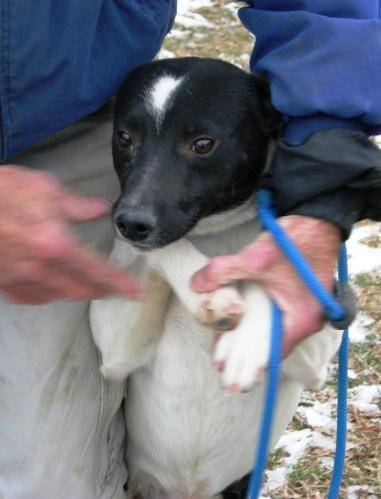

In [24]:
from PIL import Image
image = Image.open(r"resources\test\test1\1.jpg")
image

In [25]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [26]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: dogs
